# 決定木
決定木学習は 決定木 と呼ばれる 木構造のグラフ を作る機械学習手法です。機械学習の分野では学習手法も単に「決定木」と呼ばれます。


分類にも回帰にも使え、分類の場合3クラス以上の多値分類が可能です。ここでは基本となる分類のみを扱います。

分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


決定木の学習には何回まで条件分岐を繰り返すかを表す （最大の）深さ というハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。


学習の仕方にはさまざまな方法がありますが、ここではscikit-learnでも使用されている CART法 をベースとした実装を行います。この方法では学習の複雑さを減らすために、 分岐は2つに分かれるのみ になります。


以下に雛形を用意してあります。このScratchDecesionTreeClassifierDepth1クラスにコードを書き加えていってください。



## 【事前準備】

In [1]:
# scikit-learnの「set_config(display="diagram")」を使用するため、scikitlearnを最新verに更新
# !pip install scikit-learn==0.23.2 --target drive/My\ Drive/MyModule
# !pip install scikit-learn==0.23.2
# !pip list
## Google Drive上にインストールしたモジュールのインポート##
import sys
sys.path.append('/content/drive/My Drive/MyModule')

In [2]:
## モジュールのインポート ##
# 一般
import random
import math
# データ分析
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
# 決定木可視化のためのツール
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
# その他
from google.colab import drive #GoogleDriveモジュール
# drive.mount('/content/drive') #GoogleDriveのマウント

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## 【実装】

### ●ScratchDecesionTreeClassifierDepth1クラスの定義

In [3]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装
    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.node_list : リスト
      決定木のノードのリスト
      ※リストのインデックスがノードIDに相当
      　⇒　ノードIDをキーにしてノードのインスタンスにアクセス可能
    self.node_num : int
      生成するノードの数（ノードIDの最大値 + 1）
    self.node_list : 次の形のndarray, shape (self.node_id_max, )
      各ノードのハンドルのリスト
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.node_num = 1000
        self.node_id_list = []

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        self.node_list = [DummyNode() for i in range(self.node_num)]   # ノードリストを初期化
        self.root_node = DecisionTreeNode()   # ルートノードを生成
        root_node_id = self.root_node.node_id   # ルートノードのID
        self.node_list[root_node_id] = self.root_node   # ルートノードをノードリストに登録
        self.node_id_list.append(root_node_id)

        # ルートノードを親ノードに設定
        node_super = self.root_node

        # 子ノードを生成（左側と右側の２つ）
        node_left = DecisionTreeNode()
        self.node_list[node_left.node_id] = node_left
        self.node_id_list.append(node_left.node_id)
        node_right = DecisionTreeNode()
        self.node_list[node_right.node_id] = node_right
        self.node_id_list.append(node_right.node_id)

        # 親ノードの子ノードに対する情報利得IGが最大となる特徴量の決定境界を算出
        boundary_feature, boundary_value, ig = self._get_decision_boundary(X, y)
        # 親ノードに各属性をセット
        node_super.boundary_feature = boundary_feature
        node_super.boundary_value = boundary_value
        node_super.gini = self._calcurate_gini(y)
        node_super.n_sample = len(y)
        class_list, n_class_sample = np.unique(y, return_counts=True)
        node_super.class_list = class_list
        node_super.n_class_sample = n_class_sample
        node_super.class_name = class_list[np.argmax(n_class_sample)]
        node_super.node_id_left = node_left.node_id
        node_super.node_id_right = node_right.node_id

        # 分類に使用する特徴量についてXとyを昇順にソート
        X_sort, y_sort = self._sort_X_y(X, y, boundary_feature)
        # Xとyを決定境界で分割
        X_left, X_right, y_left, y_right = self._devide_X_y(X_sort, y_sort, boundary_feature, boundary_value)

        # 左側の子ノードに各属性をセット
        node_left.gini = self._calcurate_gini(y_left)
        node_left.n_sample = len(y_left)
        class_list, n_class_sample = np.unique(y_left, return_counts=True)
        node_left.class_list = class_list
        node_left.n_class_sample = n_class_sample
        node_left.class_name = class_list[np.argmax(n_class_sample)]

        # 右側の子ノードに各属性をセット
        node_right.gini = self._calcurate_gini(y_right)
        node_right.n_sample = len(y_right)
        class_list, n_class_sample = np.unique(y_right, return_counts=True)
        node_right.class_list = class_list
        node_right.n_class_sample = n_class_sample
        node_right.class_name = class_list[np.argmax(n_class_sample)]

        # 左側の子ノードのジニ不純度が0より大きい場合
        if (node_left.gini > 0):
            # ノード分割待ちリストにエンキュー
            pass
        # 右側の子ノードのジニ不純度が0より大きい場合
        if (node_right.gini > 0):
            # ノード分割待ちリストにエンキュー  
            pass

        # デバッグ情報出力
        if self.verbose:
            print("            boundary_feature:{}".format(boundary_feature))
            print("            boundary_value:{}".format(boundary_value))
            print("            ig:{}".format(ig))

        # 各子ノードのジニ不純度が0でなければ、その子ノード内で別の特徴量に着目して上記の処理を再度行う
        # 各子ノードのジニ不純度が0であれば、その子ノードの分割は終了

        return
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
        ret_y_pred : 次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        boundary_feature = self.root_node.boundary_feature
        boundary_value = self.root_node.boundary_value
        n_samples = X.shape[0]
        ret_y_pred = np.zeros(n_samples)

        for i in range(n_samples):
            if (X[i, boundary_feature] > boundary_value):
                node_id_right = self.root_node.node_id_right
                ret_y_pred[i] = self.node_list[node_id_right].class_name
            else:
                node_id_left = self.root_node.node_id_left
                ret_y_pred[i] = self.node_list[node_id_left].class_name
        return  ret_y_pred.astype(np.int64)

    def _get_decision_boundary(self, X, y):
        """
        親ノードの子ノードに対する情報利得IGが最大となる特徴量の決定境界（閾値）を算出する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        Returns
        -------
        boundary : int
            決定境界
        boundary_index : int
            決定境界よりも小さいサンプルの内、最大の特徴量を持つサンプルのインデックス
        ig : int
            決定境界で得られた情報利得
        """
        boundary_candidate_num = 10    # 決定境界の候補の数
        n_features = X.shape[1]     # 特徴量の数
        n_all = len(y)   # ノードに含まれるサンプルの総数
        ig = 0    # 情報利得IG
        boundary = 0    # 決定境界
        boundary_index = 0   # 決定境界となるデータのインデックス（行番号）

        # 親ノードのジニ不純度を取得
        gini_p = self._calcurate_gini(y)

        # 各特徴量を順番に着目
        for i in range(n_features):
            # 特徴量iに着目してXとyをソート
            X_sort, y_sort = self._sort_X_y(X, y, i)

            # 特徴量iのデータ列の最小値と最大値から、決定境界候補の間隔を決定
            x_min = X_sort[0, i]    # 最小値
            x_max = X_sort[-1, i]   # 最大値
            boundary_unit = (x_max - x_min) / (boundary_candidate_num + 1)  # 決定境界候補の間隔
            for j in range(boundary_candidate_num):
                boundary_value_temp = boundary_unit * (j + 1) + x_min   # 決定境界
                # Xとyを決定境界で分割
                X_left, X_right, y_left, y_right = self._devide_X_y(X_sort, y_sort, i, boundary_value_temp)
                # 各子ノードに対する情報利得IGを算出
                ig_temp = self._calcurate_IG(gini_p, y_left, y_right)
                # これまで得られた情報利得よりも大きければ決定境界を採用
                if (ig_temp > ig):
                    boundary_feature = i    # 特徴量のインデックス
                    boundary_value = boundary_value_temp    # 決定境界の値
                    ig = ig_temp  # 新たに取得されたIG
                
                # デバッグ情報出力
                if self.verbose:
                    print("            ■{}番目の特徴量の{}個目の決定境界候補".format(i, j))
                    print("            boundary_value_temp:{}".format(boundary_value_temp))
                    print("            ig:{}".format(ig_temp))
        return  boundary_feature, boundary_value, ig

    def _calcurate_IG(self, gini_p, y_left, y_right):
        """
        親ノードの子ノードに対する情報利得IGを算出する
        Parameters
        ----------
        gini_p : float
            親ノードのジニ不純度
        y_left : 次の形のndarray, shape (n_left_samples, )
            左側の子ノードの正解ラベル
        y_right : 次の形のndarray, shape (n_right_samples, )
            右側の子ノードの正解ラベル
        Returns
        -------
        ret_ig : float
            情報利得IG
        """
        n_left_all = len(y_left)   # 左側の子ノードに含まれるサンプルの総数
        n_right_all = len(y_right)   # 右側の子ノードに含まれるサンプルの総数
        n_all = n_left_all + n_right_all   # 親ノードに含まれるサンプルの総数

        # IG = I(p) - n_left_all/n_all * I(left) - n_right_all/n_all * I(right) を計算
        gini_left = self._calcurate_gini(y_left)
        gini_right = self._calcurate_gini(y_right)

        ret_ig = gini_p - (n_left_all / n_all) * gini_left - (n_right_all / n_all) * gini_right

        return ret_ig

    def _calcurate_gini(self, y):
        """
        ノードのジニ不純度を算出する
        Parameters
        ----------
        y : 次の形のndarray, shape (n_node_samples, )
            ノードに含まれる正解ラベル
        Returns
        -------
        ret_gini : float
            ジニ不純度
        """
        n_all = len(y)   # ノードに含まれるサンプルの総数

        # 正解ラベルのユニークな要素の種類とそれぞれの出現回数を取得
        unique_list, unique_count = np.unique(y, return_counts=True)

        # ジニ不純度 I = 1 - Σ(n_i/n_all)^2 を計算
        n_i_square_sum = (unique_count**2).sum()
        ret_gini = 1 - (1 / (n_all**2)) * n_i_square_sum

        return ret_gini

    def _sort_X_y(self, X, y, target_feature):
        """
        引数で与えられた特徴量に着目し、Xとyを昇順にソート
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        target_feature : int
            着目する特徴量
        Returns
        -------
        X_sort : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y_sort : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        # 特徴量に着目し、その特徴量が昇順になるようXとyをソート
        sort_index = np.argsort(X[:, target_feature])  # 昇順に並び替えるためのインデックスを取得
        X_sort = X[sort_index] # Xをソート
        y_sort = y[sort_index] # yをソート
        return X_sort, y_sort

    def _devide_X_y(self, X_sort, y_sort, target_feature, boundary_value):
        """
        引数で与えられた特徴量に着目し、Xとyを昇順にソート
        Parameters
        ----------
        X_sort : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y_sort : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        target_feature : int
            着目する特徴量
        boundary_value : int
            決定境界（閾値）の値
        Returns
        -------
        X_sort_left : 次の形のndarray, shape (n_samples_left, n_features)
            訓練データの特徴量(左側の子ノード用)
        X_sort_right : 次の形のndarray, shape (n_samples_right, n_features)
            訓練データの特徴量(右側の子ノード用)
        y_sort_left : 次の形のndarray, shape (n_samples, )
            訓練データの正解値(左側の子ノード用)
        y_sort_right : 次の形のndarray, shape (n_samples, )
            訓練データの正解値(右側の子ノード用)
        """
        # 決定境界よりも大きい特徴量データの内、最小のデータのインデックスを取得
        index = np.min(np.where(X_sort[:, target_feature] > boundary_value))
        # 決定境界でXとyを分割
        X_sort_left = X_sort[:index, target_feature]
        X_sort_right = X_sort[index:, target_feature]
        y_sort_left = y_sort[:index]
        y_sort_right = y_sort[index:]
        return  X_sort_left, X_sort_right, y_sort_left, y_sort_right

### ●DecisionTreeNodeクラスの定義

In [4]:
class DecisionTreeNode():
    """
    決定木のノードクラス
    Parameters
    ----------
    None
    Attributes
    ----------
    DecisionTreeNode.counter : int (クラス変数)
        インスタンス生成時にインクリメントされるカウンター
    self.node_id : int
        ノードID
    self.boundary_feature : int
        クラス判定に使用する特徴量のインデックス
    self.boundary_value : float
        特徴量の決定境界の値
    self.gini : float
        ジニ不純度
    self.n_sample : int
        ノードに含まれるサンプル数
    self.class_list : int
        クラスの一覧
    self.n_class_sample :  次の形のndarray, shape(2, )
        各クラスのサンプル数
    self.class_name : str or int
        クラス名
    self.node_id_left : int
        左側の子ノードのID
    self.node_id_right : int
        右側の子ノードのID
    None
    """
    counter = 0
    def __init__(self):
        DecisionTreeNode.counter += 1  # インスタンス生成時にカウンター（クラス変数）をインクリメント
        self.node_id = DecisionTreeNode.counter
        self.boundary_feature = 0
        self.boundary_value = 0
        self.gini = 0
        self.n_sample = 0
        self.class_list = np.array([])
        self.n_class_sample = np.zeros(2)
        self.class_name = np.array([])
        self.node_id_left = 0
        self.node_id_right = 0
        

### ●DivisionWaitingNodeクラスの定義

In [5]:
class DivisionWaitingNodeInfo():
    """
    分割待ちノードの情報を保持するクラス
    Parameters
    ----------
    node_id : int
        分割待ち状態のノードのID
    X : 次の形のndarray, shape (n_samples, n_features)
        親ノードの決定境界で分割された訓練データの特徴量
    y : 次の形のndarray, shape (n_samples, )
        親ノードの決定境界で分割された訓練データの正解ラベル
    Attributes
    ----------
    None
    """
    counter = 0
    def __init__(self, node_id, X, y):
        self.node_id = node_id
        self.X = X
        self.y = y

### ●DummyNodeクラスの定義

In [6]:
class DummyNode():
    """
    決定木のダミーノードのクラス
    Parameters
    ----------
    None
    Attributes
    ----------
    None
    """
    def __init__(self):
        pass
        

### ●推定器の評価指標を記録するスコアボードのクラス

In [7]:
## 推定器の指標値を記録するスコアボードのクラス ##
class ScoreBoard():
    def __init__(self, name1=None, name2=None):
        self.df_score = pd.DataFrame([])   #各指標値を記録するDataFrame
        if (name1 is None):   name1 = ""
        if (name2 is None):   name2 = ""
        self.name1 = name1
        self.name2 = name2
        print("{}スコアボード{}が生成されました。".format(self.name1, self.name2))
    def calcurate_scores(self, arg_y_true, arg_y_predict, arg_y_predict_proba=None, arg_columns=None):
        # Accuracy（正解率）
        accuracy = accuracy_score(arg_y_true, arg_y_predict)

        #Precision（適合率）
        precision = precision_score(arg_y_true, arg_y_predict)

        #Recall（再現率）
        recall = recall_score(arg_y_true, arg_y_predict)

        #F値
        f1 = f1_score(arg_y_true, arg_y_predict)

        #AUC
        if (arg_y_predict_proba is not None):
            roc_auc = roc_auc_score(arg_y_true, arg_y_predict_proba)
            score_list = [accuracy, precision, recall, f1, roc_auc]
            index_list = ["Accuacy", "Precision", "Recall", "F1", "ROC_AUC"]
        else:
            score_list = [accuracy, precision, recall, f1]
            index_list = ["Accuacy", "Precision", "Recall", "F1"]

        #Confusion matrix（混同行列）
        print("\n")
        print("###Confusion matrix（混同行列）###")
        print(confusion_matrix(arg_y_true, arg_y_predict))

        #指標値の比較用テーブルに登録
        # if(self.df_score.empty):
        #     self.df_score = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=["Accuacy", "Precision", "Recall", "F1", "ROC_AUC"], columns=arg_columns)
        # else:
        df_score_temp = pd.DataFrame(data=score_list, index=index_list, columns=arg_columns)
        self.df_score = pd.concat([self.df_score, df_score_temp], axis=1)
        print("\n")
        print("{}スコアボード{}:".format(self.name1, self.name2))
        display(self.df_score)

        # #ROC曲線、AUC
        # #y_testの値を2→1, 1→0に変換
        # y_test1_dummy = np.where(y_test1==1, 0, 1)
        # fpr, tpr, thresholds = metrics.roc_curve(y_test1_dummy, y_predict_proba[:, -1]) # FPR（偽陽性率）、TPR（真陽性率）、閾値を算出
        # auc = metrics.auc(fpr, tpr)  # AUCを算出
        # plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
        # plt.legend()
        # plt.title('ROC curve')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.grid(True)

        # 決定領域を描画
        # decision_region(X_train_transformed, y_train, model=clf, step=0.01, title='decision region', xlabel=df3.columns[0], ylabel=df3.columns[1], target_names=df3.iloc[:, -1].unique())
        
        return
    def display(self):
        display(self.df_score)
        return


# スコアボードをインスタンス化
score_board1 = ScoreBoard(name2 = "1")
score_board2 = ScoreBoard(name2 = "2")

スコアボード1が生成されました。
スコアボード2が生成されました。


### ●データセットの準備（シンプルデータセット２）

In [8]:
## シンプルデータセット2 ##
X = np.array([
    [-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
    [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
    [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
    [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
    [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
    [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
    [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
    [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
    [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
    [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
    [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
    [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
    [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
    [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
    [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
    [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
    [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
    [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
    [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
    [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ],
])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

df_X = pd.DataFrame(data=X, columns=["X0", "X1"])
df_y = pd.DataFrame(data=y, columns=["y"])
df_simple2 = pd.concat([df_X, df_y], axis=1)

print("df_simple2:")
display(df_simple2)

#データセットを学習用と検証用に分割
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, train_size = 0.75, random_state=0)

df_simple2:


,X0,X1,y
0,-0.446990,-2.807300,0
1,-1.462100,-2.458600,0
2,0.106450,1.924200,0
3,-3.594400,-4.011200,0
4,-0.988800,4.571800,0
5,-3.162500,-3.960600,0
6,0.564210,0.728880,0
7,-0.602160,8.463600,0
8,-0.612510,-0.753450,0
9,-0.735350,-2.271800,0


,X0,X1,y
X0,1.000000,0.292602,0.053205
X1,0.292602,1.000000,0.322704
y,0.053205,0.322704,1.000000


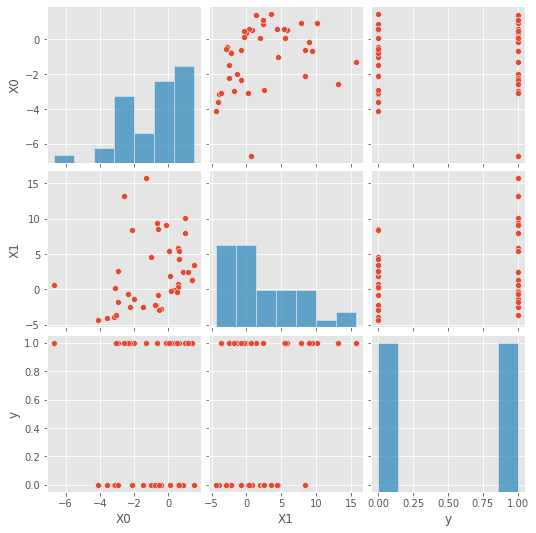

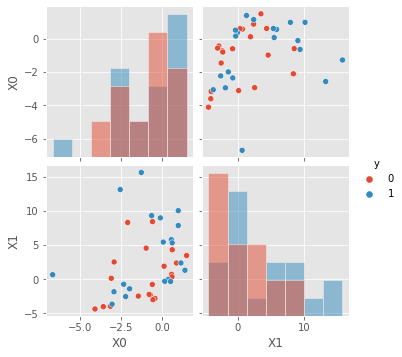

In [9]:
#相関係数
display(df_simple2.corr())

#散布図行列を作成
import seaborn as sns
sns.pairplot(df_simple2, diag_kind="hist");
sns.pairplot(df_simple2, hue="y", diag_kind="hist");

### ●【動作確認】ScratchDecesionTreeClassifierDepth1クラスを用いた分類

In [10]:
# 標準化処理とSVMをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchDecesionTreeClassifierDepth1(verbose=False)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_predict, arg_columns=["ScratchDecesionTreeClassifierDepth1"])

#モデルのインスタンスを複製
pipeline1 = pipeline

y_true:
[1 1 1 0 0 0 1 0 0 1]
y_predict:
[1 0 0 0 0 0 0 0 1 1]


###Confusion matrix（混同行列）###
[[4 1]
 [3 2]]


スコアボード1:


,ScratchDecesionTreeClassifierDepth1
Accuacy,0.600000
Precision,0.666667
Recall,0.400000
F1,0.500000


In [11]:
print(pipeline["classifier"].node_id_list)
root_node = pipeline["classifier"].root_node
print("\n")
print(pipeline["classifier"].root_node.node_id)
print(pipeline["classifier"].root_node.boundary_feature)
print(pipeline["classifier"].root_node.boundary_value)
print(pipeline["classifier"].root_node.gini)
print(pipeline["classifier"].root_node.n_sample)
print(pipeline["classifier"].root_node.n_class_sample)
print(pipeline["classifier"].root_node.class_name)
print(pipeline["classifier"].root_node.node_id_left)
print(pipeline["classifier"].root_node.node_id_right)
print("\n")
node_id_left = pipeline["classifier"].root_node.node_id_left
print(pipeline["classifier"].node_list[node_id_left].node_id)
print(pipeline["classifier"].node_list[node_id_left].boundary_feature)
print(pipeline["classifier"].node_list[node_id_left].boundary_value)
print(pipeline["classifier"].node_list[node_id_left].gini)
print(pipeline["classifier"].node_list[node_id_left].n_sample)
print(pipeline["classifier"].node_list[node_id_left].n_class_sample)
print(pipeline["classifier"].node_list[node_id_left].class_name)
print(pipeline["classifier"].node_list[node_id_left].node_id_left)
print(pipeline["classifier"].node_list[node_id_left].node_id_right)
print("\n")
node_id_right = pipeline["classifier"].root_node.node_id_right
print(pipeline["classifier"].node_list[node_id_right].node_id)
print(pipeline["classifier"].node_list[node_id_right].boundary_feature)
print(pipeline["classifier"].node_list[node_id_right].boundary_value)
print(pipeline["classifier"].node_list[node_id_right].gini)
print(pipeline["classifier"].node_list[node_id_right].n_sample)
print(pipeline["classifier"].node_list[node_id_right].n_class_sample)
print(pipeline["classifier"].node_list[node_id_right].class_name)
print(pipeline["classifier"].node_list[node_id_right].node_id_left)
print(pipeline["classifier"].node_list[node_id_right].node_id_right)

[1, 2, 3]


1
1
0.5356713620612461
0.5
30
[15 15]
0
2
3


2
0
0
0.4628099173553719
22
[14  8]
0
0
0


3
0
0
0.21875
8
[1 7]
1
0
0


### ●【比較用】scikit-learnのDecisionTreeClassifierクラスを用いた分類

In [12]:
# 標準化処理とDecisionTreeClassifierをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", DecisionTreeClassifier(random_state=0)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_predict, arg_columns=["DecisionTreeClassifier"])

#モデルのインスタンスを複製
pipeline_sklearn = pipeline

y_true:
[1 1 1 0 0 0 1 0 0 1]
y_predict:
[0 1 1 0 0 1 0 0 0 1]


###Confusion matrix（混同行列）###
[[4 1]
 [2 3]]


スコアボード1:


,ScratchDecesionTreeClassifierDepth1,DecisionTreeClassifier
Accuacy,0.600000,0.700000
Precision,0.666667,0.750000
Recall,0.400000,0.600000
F1,0.500000,0.666667


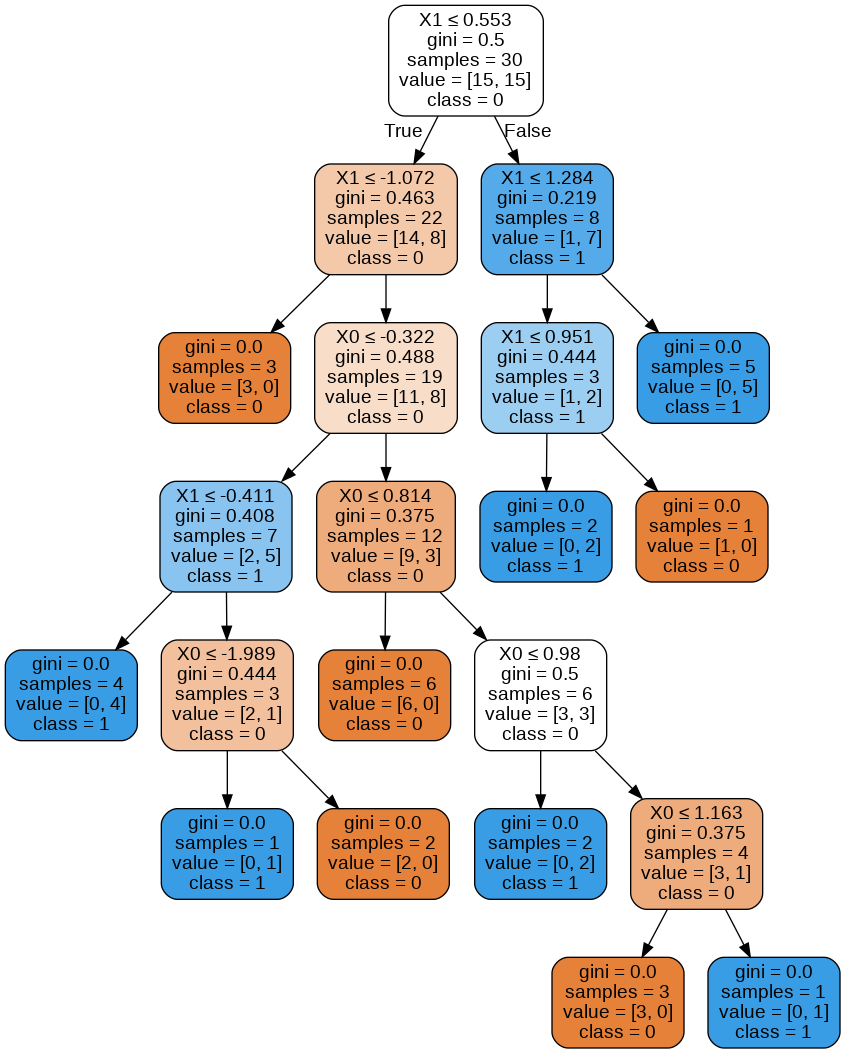

In [13]:
# 決定木の作成
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(pipeline["classifier"], out_file=dot_data,  
                     feature_names=[df_X.columns[0], df_X.columns[1]],
                     class_names=["0", "1"],
                     filled=True, rounded=True,
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

## 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード $t$ に対するジニ不純度 $I(t)$ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。

$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$
$t$ : ノードのインデックス


$i$ : クラスのインデックス


$K$ : クラスの数


$C_i$ : i番目のクラス


$P(C_i|t)$ :　t番目のノードにおける$C_i$の割合


$N_{t,i}$ : t番目のノードのi番目のクラスに属するサンプル数


$N_{t,all}$ : t番目のノードのサンプルの総数


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》


- クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
- クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
- クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
- クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

### 【問題1 解答】
ノードのジニ不純度を計算する処理を、_calcurate_giniメソッドに実装した。

## 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。


ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。


$$IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)$$
$p$ : 親ノードを示すインデックス


$left$ : 左側のノードを示すインデックス


$right$ : 右側のノードを示すインデックス


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》


左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

### 【問題2 解答】
親ノードに対する子ノードの情報利得IGを算出する処理を、_calcurate_IGメソッドに実装した。

## 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対してすべての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。


クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。


《組み合わせの取り方》


すべての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。


他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。


《補足》


問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

### 【問題3 解答】
情報利得IGが最大となる決定境界を決定する処理を、_get_decision_boundaryメソッドに実装した。

## 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。


入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

### 【問題4 解答】
fitメソッドで学習した決定境界の情報に基づいて検証データを分類する処理を、ScratchDecesionTreeClassifierDepth1クラスのpredictメソッドに実装した

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [14]:
score_board1.display()

,ScratchDecesionTreeClassifierDepth1,DecisionTreeClassifier
Accuacy,0.600000,0.700000
Precision,0.666667,0.750000
Recall,0.400000,0.600000
F1,0.500000,0.666667


### 【問題5 解答】
シンプルデータセット2についてスクラッチ実装した「ScratchDecesionTreeClassifierDepth1」クラスの推定精度を評価したところ、scikit-learnのDecisionTreeClassifierの精度には及ばなかった。ScratchDecesionTreeClassifierDepth1も決定木の深さを増やすことで精度の改善が可能と考えられる。

## 【問題6】決定領域の可視化
決定領域を可視化してください。

### ●決定領域を描画する関数

In [15]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['0', '1'], X1=None, y1=None, target_name1=None):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    X1 : ndarray, shape(n_samples, 2)
        特徴量（SVMのサポートベクター用）
    y1 : ndarray, shape(n_samples,)
        ラベル（SVMのサポートベクター用）
    target_name1
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(np.unique(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    if ((X1 is not None) and (y1 is not None)):
        plt.scatter(X1[:, 0], X1[:, 1], s=80, color="yellow", label=target_name1, marker='o')
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

### ●決定領域の描画（ScratchDecesionTreeClassifierDepth1）

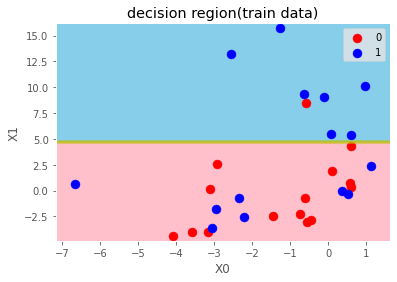

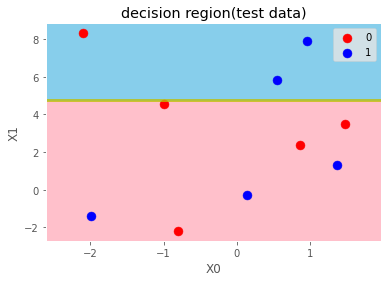

In [16]:
# 決定領域を描画（学習データ）
decision_region(X, y, model=pipeline1, step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=np.unique(y))
# 決定領域を描画（検証データ）
decision_region(Xt, yt, model=pipeline1, step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=np.unique(y))

### ●決定領域の描画（DecisionTreeClassifier）

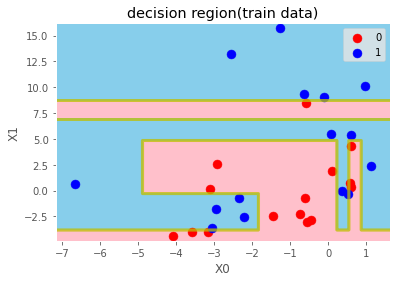

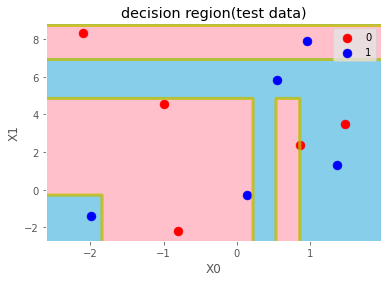

In [17]:
# 決定領域を描画（学習データ）
decision_region(X, y, model=pipeline_sklearn, step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=np.unique(y))
# 決定領域を描画（検証データ）
decision_region(Xt, yt, model=pipeline_sklearn, step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=np.unique(y))

## 【問題8】（アドバンス課題）深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。


任意の深さを指定できるようにするとともに、指定しない場合はすべての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

### ●ScratchDecesionTreeClassifierDepthInfクラスの定義

In [18]:
class ScratchDecesionTreeClassifierDepthInf():
    """
    深さ制限のない決定木分類器のスクラッチ実装
    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.node_list : リスト
      決定木のノードのリスト
      ※リストのインデックスがノードIDに相当
      　⇒　ノードIDをキーにしてノードのインスタンスにアクセス可能
    self.node_num : int
      生成するノードの数（ノードIDの最大値 + 1）
    self.node_list : 次の形のndarray, shape (self.node_id_max, )
      各ノードのハンドルのリスト
    self.division_wait_node_list : リスト
      分割処理（決定境界の決定など）を待つノードのリスト（スタック）
    self.df_nodes_info : DataFrame
      各ノードの情報を保持するテーブル
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.node_num = 1000

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        # 初期化
        self.node_list = [DummyNode() for i in range(self.node_num)]   # ノードリスト
        self.node_id_list = []   # ノードIDリスト
        self.division_wait_node_list = []   # 分割待ちノード情報リスト
        self.df_node = pd.DataFrame(data=[])    # ノード情報テーブル

        self.root_node = DecisionTreeNode()   # ルートノードを生成
        root_node_id = self.root_node.node_id   # ルートノードのID
        self.node_list[root_node_id] = self.root_node   # ルートノードをノードリストに登録
        self.node_id_list.append(root_node_id)

        # ルートノードに各属性をセット
        self.root_node.gini = self._calcurate_gini(y)   # ジニ係数
        self.root_node.n_sample = len(y)    # ノードに含まれるサンプルの総数
        class_list, n_class_sample = np.unique(y, return_counts=True)
        self.root_node.class_list = class_list    # ノードに含まれるサンプルのクラスのリスト
        self.root_node.n_class_sample = n_class_sample    # ノードに含まれる各クラスのサンプル数
        self.root_node.class_name = class_list[np.argmax(n_class_sample)]    # 親ノードのクラス

        # ルートノードのノード情報を生成
        waiting_node_info = DivisionWaitingNodeInfo(self.root_node.node_id, X, y)
        # ルートノードのノード情報を分割待ちノードリストにプッシュ
        self.division_wait_node_list.append(waiting_node_info)

        # 分割待ちノードリストが空になるまで（＝全ての葉ノードのジニ不純度が0になるまで）ループ
        while (len(self.division_wait_node_list) != 0):
            # 分割待ちノードリストから分割待ちノードの情報をポップ
            node_info = self.division_wait_node_list.pop()
            # ポップしたノードを親ノードとして設定
            node_super = self.node_list[node_info.node_id]
            # 分割待ちノード情報に退避していた特徴量データXと正解ラベルyをローカル変数に格納
            X = node_info.X
            y = node_info.y

            # デバッグ情報出力
            if self.verbose:
                print("            node_info.node_id:{}".format(node_info.node_id))
                print("            X:{}".format(X))
                print("            y:{}".format(y))

            # 子ノードを生成（左側と右側の２つ）
            node_left = DecisionTreeNode()
            node_right = DecisionTreeNode()
            # 子ノードをノードリストに登録
            self.node_list[node_left.node_id] = node_left
            self.node_list[node_right.node_id] = node_right
            # 子ノードのIDをノードIDリストに登録
            self.node_id_list.append(node_left.node_id)
            self.node_id_list.append(node_right.node_id)

            # 親ノードの子ノードに対する情報利得IGが最大となる特徴量の決定境界を算出
            boundary_feature, boundary_value, ig = self._get_decision_boundary(X, y)

            # 親ノードに各属性をセット
            node_super.boundary_feature = boundary_feature  # 決定境界として使用する特徴量の種類
            node_super.boundary_value = boundary_value  # 決定境界として使用する特徴量の閾値
            node_super.node_id_left = node_left.node_id   # 左側の子ノードのID
            node_super.node_id_right = node_right.node_id   # 右側の子ノードのID

            # 分類に使用する特徴量についてXとyを昇順にソート
            X_sort, y_sort = self._sort_X_y(X, y, boundary_feature)
            # Xとyを決定境界で分割
            X_left, X_right, y_left, y_right = self._devide_X_y(X_sort, y_sort, boundary_feature, boundary_value)

            # 左側の子ノードに各属性をセット
            node_left.gini = self._calcurate_gini(y_left)   # ジニ係数
            node_left.n_sample = len(y_left)    # ノードに含まれるサンプルの総数
            class_list, n_class_sample = np.unique(y_left, return_counts=True)
            node_left.class_list = class_list    # ノードに含まれるサンプルのクラスのリスト
            node_left.n_class_sample = n_class_sample    # ノードに含まれる各クラスのサンプル数
            node_left.class_name = class_list[np.argmax(n_class_sample)]    # 親ノードのクラス

            # 右側の子ノードに各属性をセット
            node_right.gini = self._calcurate_gini(y_right)   # ジニ係数
            node_right.n_sample = len(y_right)    # ノードに含まれるサンプルの総数
            class_list, n_class_sample = np.unique(y_right, return_counts=True)
            node_right.class_list = class_list    # ノードに含まれるサンプルのクラスのリスト
            node_right.n_class_sample = n_class_sample    # ノードに含まれる各クラスのサンプル数
            node_right.class_name = class_list[np.argmax(n_class_sample)]    # 親ノードのクラス

            # 左側の子ノードのジニ不純度が0より大きい場合
            if (node_left.gini > 0):
                # ノード分割待ちリストにプッシュ
                waiting_node_info = DivisionWaitingNodeInfo(node_left.node_id, X_left, y_left)
                self.division_wait_node_list.append(waiting_node_info)
                
            # 右側の子ノードのジニ不純度が0より大きい場合
            if (node_right.gini > 0):
                # ノード分割待ちリストにプッシュ
                waiting_node_info = DivisionWaitingNodeInfo(node_right.node_id, X_right, y_right)
                self.division_wait_node_list.append(waiting_node_info)

            # デバッグ情報出力
            if self.verbose:
                print("            boundary_feature:{}".format(boundary_feature))
                print("            boundary_value:{}".format(boundary_value))
                print("            ig:{}".format(ig))

        # 各子ノードのジニ不純度が0でなければ、その子ノード内で別の特徴量に着目して上記の処理を再度行う
        # 各子ノードのジニ不純度が0であれば、その子ノードの分割は終了

        # 各ノードの情報を記載したテーブルを作成
        self._create_nodes_info_table()

        return
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
        ret_y_pred : 次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        n_samples = X.shape[0]    # サンプル数
        ret_y_pred = np.zeros(n_samples)    # ラベルの推定値

        # 全サンプルについて推定開始
        for i in range(n_samples):
            # ルートノードを現在のノードに設定
            current_node = self.root_node
            # デバッグ情報出力
            if self.verbose:    print("            ■{}番目のデータの推定開始".format(i));
                
            while True:
                # デバッグ情報出力
                if self.verbose:    print("             node_id:{}".format(current_node.node_id));

                # 現在のノードのジニ不純度が0の場合
                if (current_node.gini == 0):
                    # yの推定値に現在ノードのクラス名をセットしてwhileループを抜ける
                    ret_y_pred[i] = current_node.class_name
                    # デバッグ情報出力
                    if self.verbose:    print("            class_name:{}".format(current_node.class_name));
                    break
                # 現在のノードのジニ不純度が0でない場合
                else:
                    # 現在ノードの決定境界の情報を取得
                    boundary_feature = current_node.boundary_feature    # 決定境界の特徴量の種別
                    boundary_value = current_node.boundary_value    # 決定境界の閾値
                    # 推定対象の特徴量データが決定境界より大きい場合
                    if (X[i, boundary_feature] > boundary_value):
                        # 右側の子ノードを現在ノードに設定
                        node_id = current_node.node_id_right
                        current_node = self.node_list[node_id]
                    # 推定対象の特徴量データが決定境界より小さい場合
                    else:
                        # 左側の子ノードを現在ノードに設定
                        node_id = current_node.node_id_left
                        current_node = self.node_list[node_id]
                    # デバッグ情報出力
                    if self.verbose:
                        print("             boundary_feature:{}".format(boundary_feature))
                        print("             boundary_value:{}".format(boundary_value))
                        print("             X[{}, {}]: {}".format(i, boundary_feature, X[i, boundary_feature]))
                        print("             next node_id: {}".format(node_id))
        return  ret_y_pred.astype(np.int64)

    def _get_decision_boundary(self, X, y):
        """
        親ノードの子ノードに対する情報利得IGが最大となる特徴量の決定境界（閾値）を算出する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        Returns
        -------
        boundary : int
            決定境界
        boundary_index : int
            決定境界よりも小さいサンプルの内、最大の特徴量を持つサンプルのインデックス
        ig : int
            決定境界で得られた情報利得
        """
        boundary_candidate_num = 10    # 決定境界の候補の数
        n_features = X.shape[1]     # 特徴量の数
        n_all = len(y)   # ノードに含まれるサンプルの総数
        ig = 0    # 情報利得IG
        boundary = 0    # 決定境界
        boundary_index = 0   # 決定境界となるデータのインデックス（行番号）

        # 親ノードのジニ不純度を取得
        gini_p = self._calcurate_gini(y)

        # 各特徴量を順番に着目
        for i in range(n_features):
            # 特徴量iに着目してXとyをソート
            X_sort, y_sort = self._sort_X_y(X, y, i)

            # 特徴量iのデータ列の最小値と最大値から、決定境界候補の間隔を決定
            x_min = X_sort[0, i]    # 最小値
            x_max = X_sort[-1, i]   # 最大値
            boundary_unit = (x_max - x_min) / (boundary_candidate_num + 1)  # 決定境界候補の間隔
            for j in range(boundary_candidate_num):
                boundary_value_temp = boundary_unit * (j + 1) + x_min   # 決定境界
                # Xとyを決定境界で分割
                X_left, X_right, y_left, y_right = self._devide_X_y(X_sort, y_sort, i, boundary_value_temp)
                # 各子ノードに対する情報利得IGを算出
                ig_temp = self._calcurate_IG(gini_p, y_left, y_right)
                # これまで得られた情報利得よりも大きければ決定境界を採用
                if (ig_temp > ig):
                    boundary_feature = i    # 特徴量のインデックス
                    boundary_value = boundary_value_temp    # 決定境界の値
                    ig = ig_temp  # 新たに取得されたIG
                
                # デバッグ情報出力
                if self.verbose:
                    print("            ■{}番目の特徴量の{}個目の決定境界候補".format(i, j))
                    print("            boundary_value_temp:{}".format(boundary_value_temp))
                    print("            ig:{}".format(ig_temp))
        return  boundary_feature, boundary_value, ig

    def _calcurate_IG(self, gini_p, y_left, y_right):
        """
        親ノードの子ノードに対する情報利得IGを算出する
        Parameters
        ----------
        gini_p : float
            親ノードのジニ不純度
        y_left : 次の形のndarray, shape (n_left_samples, )
            左側の子ノードの正解ラベル
        y_right : 次の形のndarray, shape (n_right_samples, )
            右側の子ノードの正解ラベル
        Returns
        -------
        ret_ig : float
            情報利得IG
        """
        n_left_all = len(y_left)   # 左側の子ノードに含まれるサンプルの総数
        n_right_all = len(y_right)   # 右側の子ノードに含まれるサンプルの総数
        n_all = n_left_all + n_right_all   # 親ノードに含まれるサンプルの総数

        # IG = I(p) - n_left_all/n_all * I(left) - n_right_all/n_all * I(right) を計算
        gini_left = self._calcurate_gini(y_left)
        gini_right = self._calcurate_gini(y_right)

        ret_ig = gini_p - (n_left_all / n_all) * gini_left - (n_right_all / n_all) * gini_right

        return ret_ig

    def _calcurate_gini(self, y):
        """
        ノードのジニ不純度を算出する
        Parameters
        ----------
        y : 次の形のndarray, shape (n_node_samples, )
            ノードに含まれる正解ラベル
        Returns
        -------
        ret_gini : float
            ジニ不純度
        """
        n_all = len(y)   # ノードに含まれるサンプルの総数

        # 正解ラベルのユニークな要素の種類とそれぞれの出現回数を取得
        unique_list, unique_count = np.unique(y, return_counts=True)

        # ジニ不純度 I = 1 - Σ(n_i/n_all)^2 を計算
        n_i_square_sum = (unique_count**2).sum()
        ret_gini = 1 - (1 / (n_all**2)) * n_i_square_sum

        return ret_gini

    def _sort_X_y(self, X, y, target_feature):
        """
        引数で与えられた特徴量に着目し、Xとyを昇順にソート
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        target_feature : int
            着目する特徴量
        Returns
        -------
        X_sort : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y_sort : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        # 特徴量に着目し、その特徴量が昇順になるようXとyをソート
        sort_index = np.argsort(X[:, target_feature])  # 昇順に並び替えるためのインデックスを取得
        X_sort = X[sort_index] # Xをソート
        y_sort = y[sort_index] # yをソート
        return X_sort, y_sort

    def _devide_X_y(self, X_sort, y_sort, target_feature, boundary_value):
        """
        引数で与えられた特徴量に着目し、Xとyを昇順にソート
        Parameters
        ----------
        X_sort : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y_sort : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        target_feature : int
            着目する特徴量
        boundary_value : int
            決定境界（閾値）の値
        Returns
        -------
        X_sort_left : 次の形のndarray, shape (n_samples_left, n_features)
            訓練データの特徴量(左側の子ノード用)
        X_sort_right : 次の形のndarray, shape (n_samples_right, n_features)
            訓練データの特徴量(右側の子ノード用)
        y_sort_left : 次の形のndarray, shape (n_samples, )
            訓練データの正解値(左側の子ノード用)
        y_sort_right : 次の形のndarray, shape (n_samples, )
            訓練データの正解値(右側の子ノード用)
        """
        # 決定境界よりも大きい特徴量データの内、最小のデータのインデックスを取得
        index = np.min(np.where(X_sort[:, target_feature] > boundary_value))
        # 決定境界でXとyを分割
        X_sort_left = X_sort[:index, :]
        X_sort_right = X_sort[index:, :]
        y_sort_left = y_sort[:index]
        y_sort_right = y_sort[index:]
        return  X_sort_left, X_sort_right, y_sort_left, y_sort_right

    def _create_nodes_info_table(self):
        """
        引数で与えられた特徴量に着目し、Xとyを昇順にソート
        Parameters
        ----------
        None
        Returns
        -------
        None
        """
        self.df_nodes_info = pd.DataFrame(data=[])
        for node_id in self.node_id_list:
            self.df_nodes_info.loc["node_id", str(node_id)]          = self.node_list[node_id].node_id
            self.df_nodes_info.loc["boundary_feature", str(node_id)] = self.node_list[node_id].boundary_feature
            self.df_nodes_info.loc["boundary_value", str(node_id)]   = self.node_list[node_id].boundary_value
            self.df_nodes_info.loc["gini", str(node_id)]             = self.node_list[node_id].gini
            self.df_nodes_info.loc["n_sample", str(node_id)]         = self.node_list[node_id].n_sample
            self.df_nodes_info.loc["class_list", str(node_id)]       = str(self.node_list[node_id].class_list)
            self.df_nodes_info.loc["n_class_sample", str(node_id)]   = str(self.node_list[node_id].n_class_sample)
            self.df_nodes_info.loc["class", str(node_id)]       = self.node_list[node_id].class_name
            self.df_nodes_info.loc["node_id_left", str(node_id)]     = self.node_list[node_id].node_id_left
            self.df_nodes_info.loc["node_id_right", str(node_id)]    = self.node_list[node_id].node_id_right
        print("ノード一覧:")
        display(self.df_nodes_info)
        return

### ●【動作確認】ScratchDecesionTreeClassifierDepthInfクラスを用いた分類（対象：シンプルデータセット2）

In [19]:
# 標準化処理とSVMをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchDecesionTreeClassifierDepthInf(verbose=False)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_predict, arg_columns=["ScratchDecesionTreeClassifierDepthInf"])

#モデルのインスタンスを複製
pipeline_inf = pipeline

ノード一覧:


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
node_id,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
boundary_feature,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
boundary_value,0.535671,-2.57638,0.514599,1.35563,0,0,0,0,1.04734,-0.283798,0,-1.09407,0,0,-0.461431,-0.458039,0.499876,0,0.973975,0,0,0,0
gini,0.5,0.46281,0.21875,0.375,0,0,0,0,0.444444,0.42,0,0.46875,0,0,0.497041,0.32,0.375,0,0.444444,0,0,0,0
n_sample,30,22,8,4,4,1,3,1,21,20,1,16,4,3,13,5,8,5,3,2,1,4,1
class_list,[0 1],[0 1],[0 1],[0 1],[1],[0],[1],[1],[0 1],[0 1],[1],[0 1],[0],[0],[0 1],[0 1],[0 1],[0],[0 1],[1],[0],[1],[0]
n_class_sample,[15 15],[14 8],[1 7],[1 3],[4],[1],[3],[1],[14 7],[14 6],[1],[10 6],[4],[3],[7 6],[1 4],[6 2],[5],[1 2],[2],[1],[4],[1]
class,0,0,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0
node_id_left,5,11,7,9,0,0,0,0,13,15,0,17,0,0,19,25,21,0,23,0,0,0,0
node_id_right,6,12,8,10,0,0,0,0,14,16,0,18,0,0,20,26,22,0,24,0,0,0,0


y_true:
[1 1 1 0 0 0 1 0 0 1]
y_predict:
[1 0 1 0 0 1 1 1 0 1]


###Confusion matrix（混同行列）###
[[3 2]
 [1 4]]


スコアボード1:


,ScratchDecesionTreeClassifierDepth1,DecisionTreeClassifier,ScratchDecesionTreeClassifierDepthInf
Accuacy,0.600000,0.700000,0.700000
Precision,0.666667,0.750000,0.666667
Recall,0.400000,0.600000,0.800000
F1,0.500000,0.666667,0.727273


### ●決定領域の描画（ScratchDecesionTreeClassifierDepthInf）

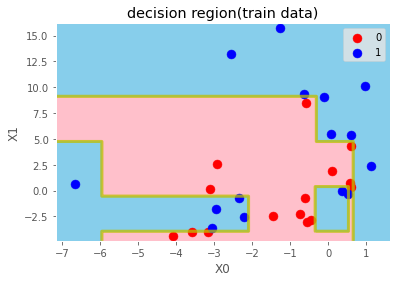

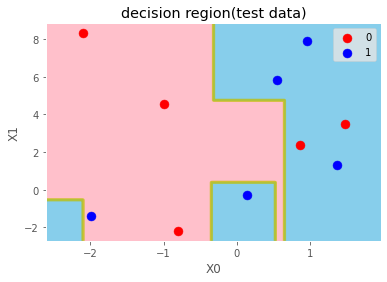

In [20]:
# 決定領域を描画（学習データ）
decision_region(X, y, model=pipeline_inf, step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=np.unique(y))
# 決定領域を描画（検証データ）
decision_region(Xt, yt, model=pipeline_inf, step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=np.unique(y))

### 【問題8 解答】
深さ制限のない決定木クラスを作成した結果、推定精度が深さ＝１の時よりも向上した。また、AccuracyやPrecision以外の評価指標についてはDecisionTreeClassifierクラスを上回った。

## 【おまけ】シンプルデータセット1を対象に動作確認

### ●データセットの準備（シンプルデータセット1）

In [21]:
## シンプルデータセット1 ##
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

df_X = pd.DataFrame(data=X, columns=["X0", "X1"])
df_y = pd.DataFrame(data=y, columns=["y"])
df_simple1 = pd.concat([df_X, df_y], axis=1)

print("df_simple1:")
display(df_simple1)

#データセットを学習用と検証用に分割
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, train_size = 0.75, random_state=0)

df_simple1:


,X0,X1,y
0,-2.800068,0.453014,1
1,-2.637145,1.780120,1
2,-2.462679,-0.080763,1
3,-1.853470,1.050804,1
4,-1.031921,2.227765,1
...,...,...,...
495,1.525060,-1.361861,-1
496,2.682255,-0.165458,-1
497,1.595155,-1.143723,-1
498,2.158431,-0.781996,-1


,X0,X1,y
X0,1.000000,-0.471745,-0.842276
X1,-0.471745,1.000000,0.836915
y,-0.842276,0.836915,1.000000


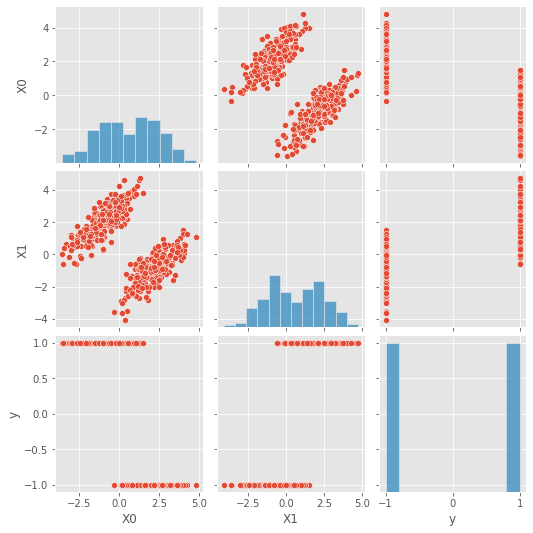

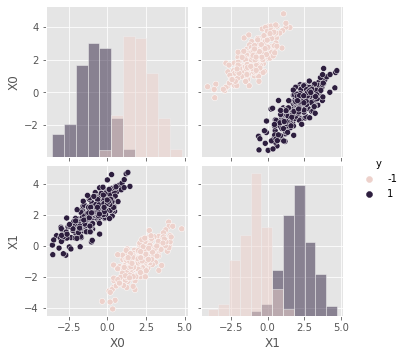

In [22]:
#相関係数
display(df_simple1.corr())

#散布図行列を作成
import seaborn as sns
sns.pairplot(df_simple1, diag_kind="hist");
sns.pairplot(df_simple1, hue="y", diag_kind="hist");

### ●【動作確認】ScratchDecesionTreeClassifierDepthInfクラスを用いた分類（対象：シンプルデータセット1）

In [23]:
# 標準化処理とSVMをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchDecesionTreeClassifierDepthInf(verbose=False)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train2
Xt = X_test2
y = y_train2
yt = y_test2
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board2.calcurate_scores(yt, y_predict, arg_columns=["ScratchDecesionTreeClassifierDepthInf"])

#モデルのインスタンスを複製
pipeline_inf = pipeline

ノード一覧:


,27,28,29,30,31,32,33,34,35,36,37,38,39
node_id,27,28,29,30,31,32,33,34,35,36,37,38,39
boundary_feature,0,1,1,0,0,0,0,0,1,0,0,0,0
boundary_value,0.0903559,-1.0763,0.412392,0.281324,0,0,0,0,-0.365745,-1.41129,0,0,0
gini,0.499996,0.114952,0.043694,1.11022e-16,0,0,0,0,0.0107524,0.32,0,0,0
n_sample,375,196,179,175,4,11,164,11,185,5,180,4,1
class_list,[-1 1],[-1 1],[-1 1],[-1],[1],[-1],[-1],[-1],[-1 1],[-1 1],[1],[1],[-1]
n_class_sample,[187 188],[ 12 184],[175 4],[175],[4],[11],[164],[11],[ 1 184],[1 4],[180],[4],[1]
class,1,1,-1,-1,1,-1,-1,-1,1,1,1,1,-1
node_id_left,28,34,30,32,0,0,0,0,36,38,0,0,0
node_id_right,29,35,31,33,0,0,0,0,37,39,0,0,0


y_true:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1]
y_predict:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1]


###Confusion matrix（混同行列）###
[[62  1]
 [ 0 62]]


スコアボード2:


,ScratchDecesionTreeClassifierDepthInf
Accuacy,0.992000
Precision,0.984127
Recall,1.000000
F1,0.992000


### ●決定領域の描画（ScratchDecesionTreeClassifierDepthInf）

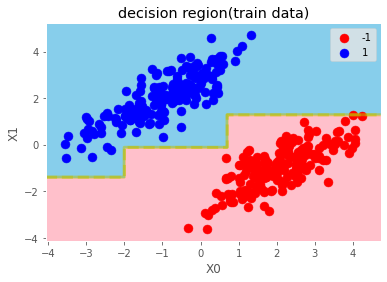

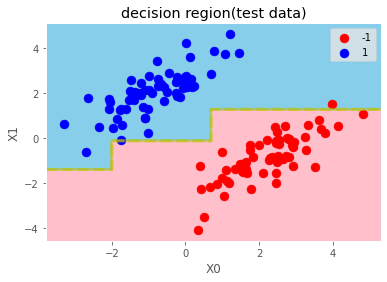

In [24]:
# 決定領域を描画（学習データ）
decision_region(X, y, model=pipeline_inf, step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=np.unique(y))
# 決定領域を描画（検証データ）
decision_region(Xt, yt, model=pipeline_inf, step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=np.unique(y))